In [ ]:
import pandas as pd
import numpy as np
from itertools import accumulate

In [ ]:
cert_data = pd.read_csv('/content/drive/MyDrive/НИР Магистратура/Работа со всеми данными/Аугментация/Preprocessed_DF', index_col=0)

Для машинного обучения, как правило, требуется существенный объем данных. В данном случае, из-за ограниченности выборки и возможностей для проведения опроса, имеется всего 257 объектов для обработки. Специфика задачи клластеризации заключается в том, что (**(инструкция для меня)**описать генерацию значений применительно к задаче кластеризации). Для увеличения массива данных для обучения можно прибегнуть к двум инструментам: проведение дополнительного опроса и автоматическая генерация синтетических данных. Дополнительных опрос должен быть проведен, но даже с учетом дополнительного опроса маловероятно, что получится получить кратно большее количество данных. С помощью автоматической генерации данных же возможно неограниченно увеличить набор данных, если о рассматриваемых данных можно предположить, что они имеют случайное распределение.
В данном случае можно выдвинуть предположение о случайном характере распределения, опираясь на биологические и приобретенные в ходе жизни различия в знаниях тестируемых.

Из распределений, в силу их дискретности, довольно сложно предположить, какого действительное распределение данного признака на генеральной совокупности. Однако, дискретностью значений можно воспользоваться для генерации дополнительных значений для набора данных.

In [ ]:
cert_data.columns

Index(['number', 'user', 'ip', 'mailbox', 'surname', 'company', 'job_title',
       'degree', 'endtime', 'c_quantity',
       ...
       'duration_89', 'duration_90', 'duration_91', 'duration_92',
       'duration_93', 'duration_94', 'duration_95', 'duration_96',
       'duration_97', 'is_quick_session'],
      dtype='object', length=328)

In [ ]:
for i in (x for x in cert_data.columns if 'duration' in x):
    cert_data[i] = cert_data[i].map(pd.Timedelta)

<Axes: >

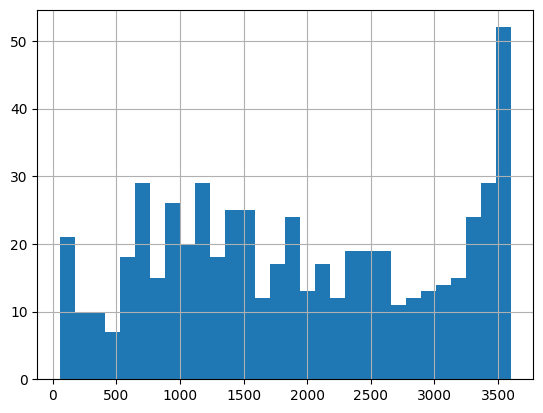

In [ ]:
cert_data['duration'].map(pd.Timedelta.total_seconds).hist(bins=30)

<Axes: >

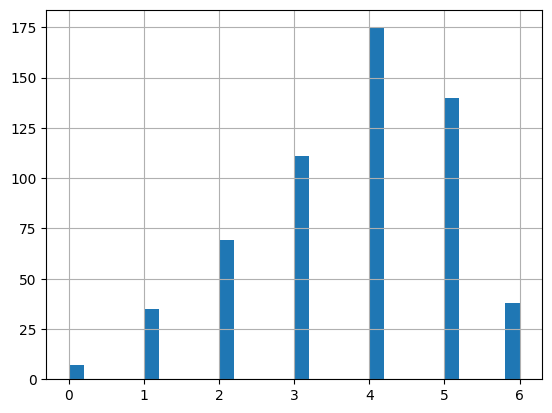

In [ ]:
cert_data['block_1_c_quantity'].hist(bins=30)

Воспользовавшись дискретностью имеющихся значений напишем функцию для генерации аналогичного распределения случайной величины исходя из имеющихся псевдослучайных генераторов равномерного распределения.

In [ ]:
def generate_random_variables(column, number_values=0):
    # Определение размера генерируемого множества значений
    if number_values == 0:
        number_values = column.count()
    column = column.copy()

    # Задание классификатора
    scale = list(accumulate(column.value_counts().values))
    values = list(column.value_counts().index)
    s = np.random.uniform(0, scale[-1], number_values)

    # Распределение значений
    generated = []
    for i in s:
        for j, k in enumerate(scale):
            if i < k:
                generated.append(values[j])
                break

    return generated

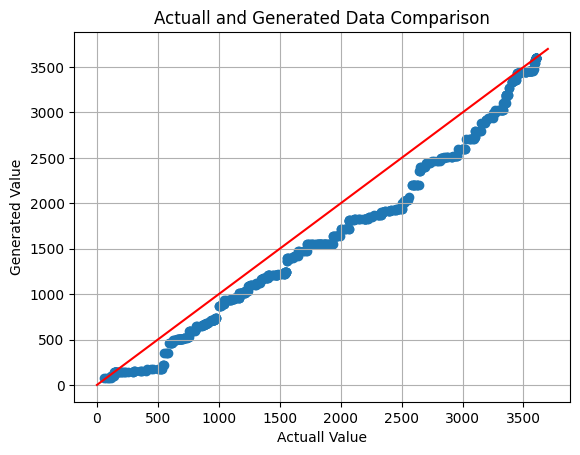

In [ ]:
import matplotlib.pyplot as plt

row_to_generate = cert_data['duration'].map(pd.Timedelta.total_seconds)
plt.scatter(list(row_to_generate.sort_values().values),
            sorted(generate_random_variables(cert_data['duration'].map(pd.Timedelta.total_seconds)[::5], cert_data.shape[0])))
plt.title('Actuall and Generated Data Comparison')
plt.xlabel('Actuall Value')
plt.ylabel('Generated Value')
plt.plot([0, 3700], [0, 3700], color='r')
plt.grid()

Функция, для генерации синтетических данных довольно хорошо себя показывает, в том числе для генерации временных значений. Следовательно, данная функция может быть применена для генерации синтетических данных для важных для модели столбцов. Видно, что на большом количестве значений удается приблизить даже распределение общего количества правильных ответов за тест. Однако, так как эта величина полносью определяется распределением правильных ответов по блокам, было принято решение не приближать данное значеине, а рассчитывать его исхожя из сгенерированных по блокам значений.

In [ ]:
generate_data_for = [x for x in cert_data.columns if (x.endswith('quantity') and x.startswith('block'))]

In [ ]:
generated_data = dict()
number_of_rows = 600000

for column_name in generate_data_for:
    generated_data[column_name] = generate_random_variables(cert_data[column_name], number_of_rows)

In [ ]:
generated_df = pd.DataFrame(generated_data)

In [ ]:
generated_df['c_quantity'] = pd.Series(dtype=int)
generated_df['c_quantity'] = generated_df['c_quantity'].fillna(0)
for i in range(1, 13):
    generated_df['c_quantity'] += generated_df[f'block_{i}_c_quantity']
generated_df['c_quantity'] = generated_df['c_quantity'].astype(int)

In [ ]:
generated_df

,block_1_c_quantity,block_2_c_quantity,block_3_c_quantity,block_4_c_quantity,block_5_c_quantity,block_6_c_quantity,block_7_c_quantity,block_8_c_quantity,block_9_c_quantity,block_10_c_quantity,block_11_c_quantity,block_12_c_quantity,c_quantity
0,5,4,2,3,4,4,4,3,1,2,2,2,36
1,4,4,3,2,4,2,4,5,3,1,1,3,36
2,3,5,1,2,0,3,4,3,3,0,3,1,28
3,4,3,1,0,3,1,5,4,2,3,2,1,29
4,5,3,2,2,2,3,4,3,4,2,1,2,33
...,...,...,...,...,...,...,...,...,...,...,...,...,...
599995,4,4,2,2,2,4,4,3,2,4,3,3,37
599996,2,4,0,3,3,1,3,3,3,4,2,2,30
599997,4,5,1,1,5,2,0,4,2,0,0,2,26
599998,4,1,1,3,2,3,5,3,3,1,2,3,31


<Axes: >

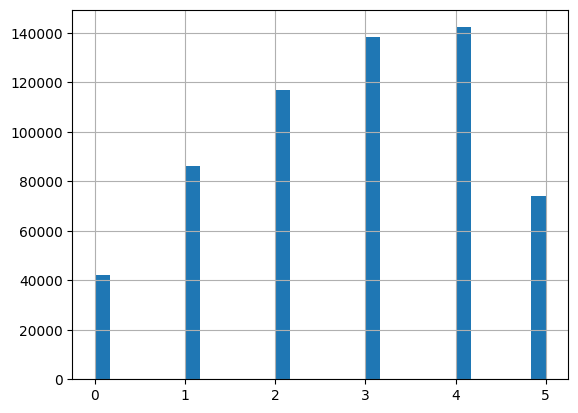

In [ ]:
generated_df['block_4_c_quantity'].hist(bins=30)

<Axes: >

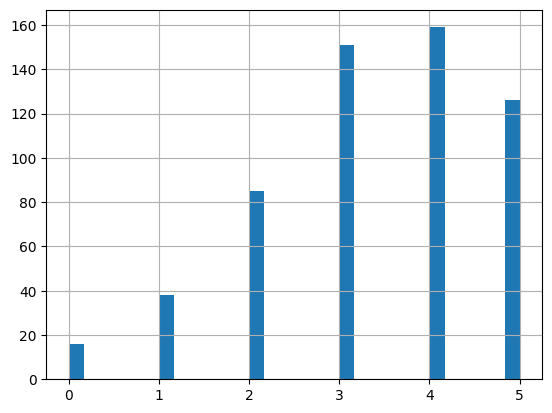

In [ ]:
cert_data['block_2_c_quantity'].hist(bins=30)

<Axes: >

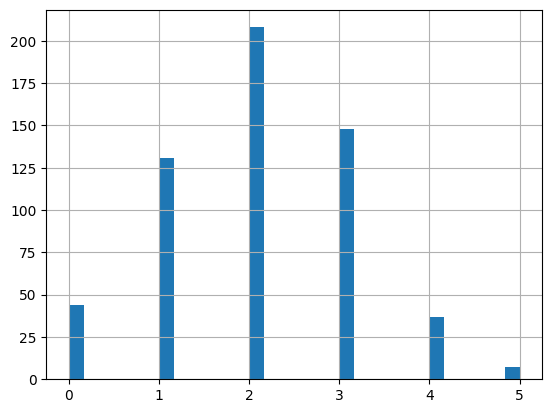

In [ ]:
cert_data['block_3_c_quantity'].hist(bins=30)

<Axes: >

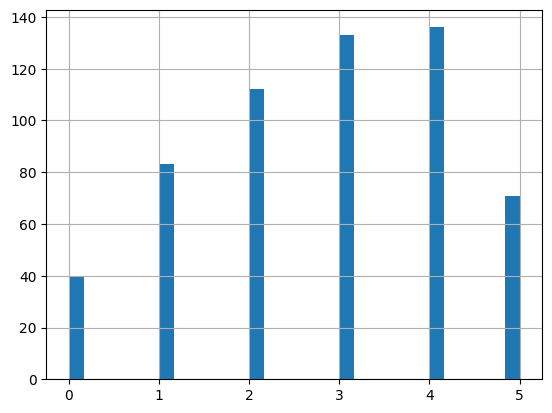

In [ ]:
cert_data['block_4_c_quantity'].hist(bins=30)

<Axes: >

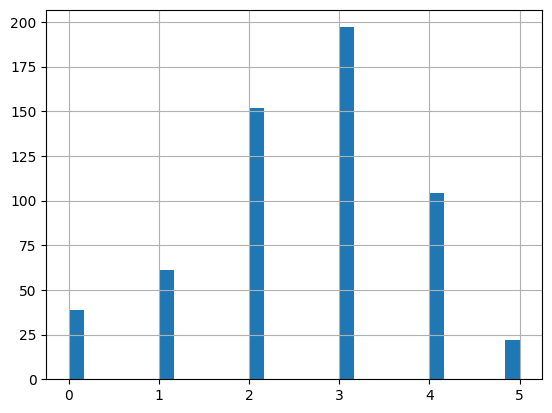

In [ ]:
cert_data['block_5_c_quantity'].hist(bins=30)

<Axes: >

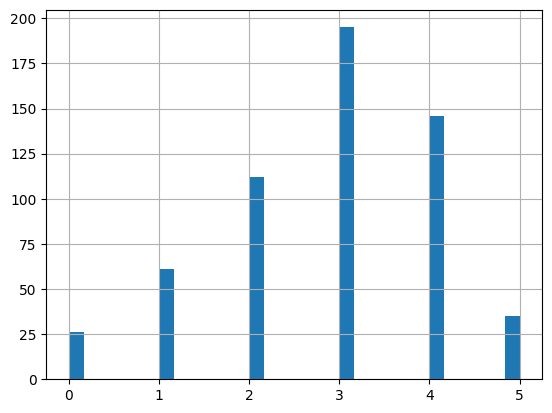

In [ ]:
cert_data['block_6_c_quantity'].hist(bins=30)

<Axes: >

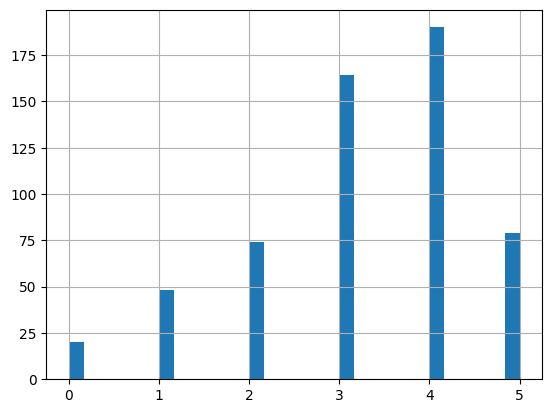

In [ ]:
cert_data['block_7_c_quantity'].hist(bins=30)

<Axes: >

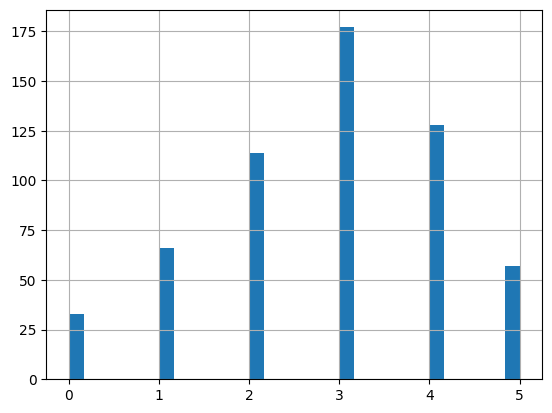

In [ ]:
cert_data['block_8_c_quantity'].hist(bins=30)

<Axes: >

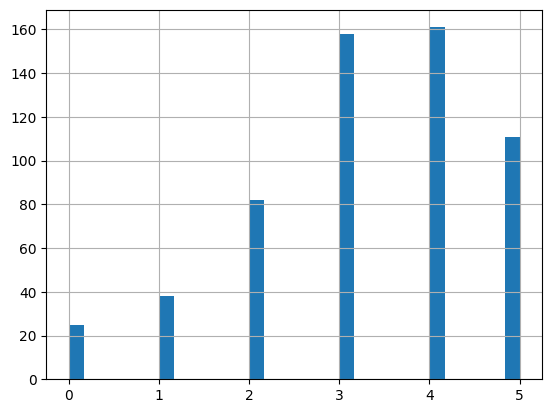

In [ ]:
cert_data['block_9_c_quantity'].hist(bins=30)

<Axes: >

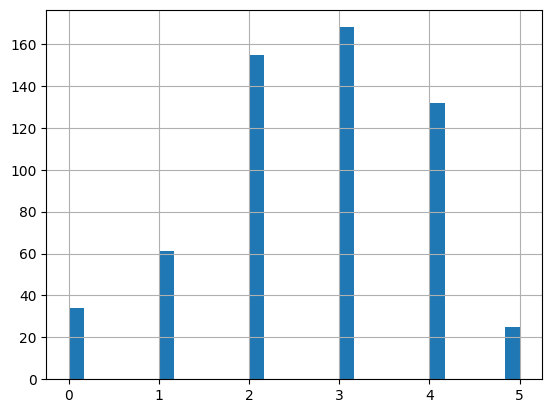

In [ ]:
cert_data['block_10_c_quantity'].hist(bins=30)

<Axes: >

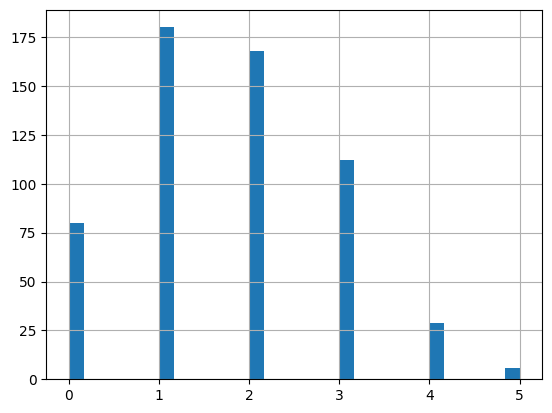

In [ ]:
cert_data['block_11_c_quantity'].hist(bins=30)

<Axes: >

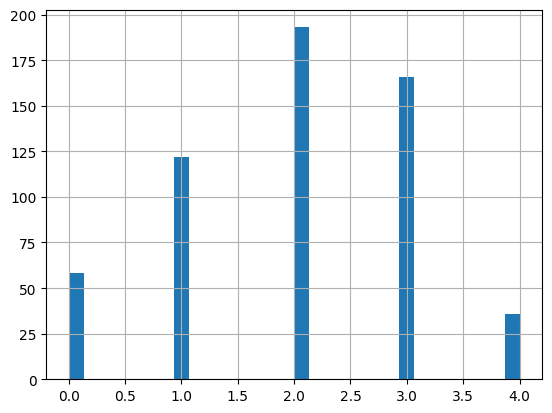

In [ ]:
cert_data['block_12_c_quantity'].hist(bins=30)

<Axes: >

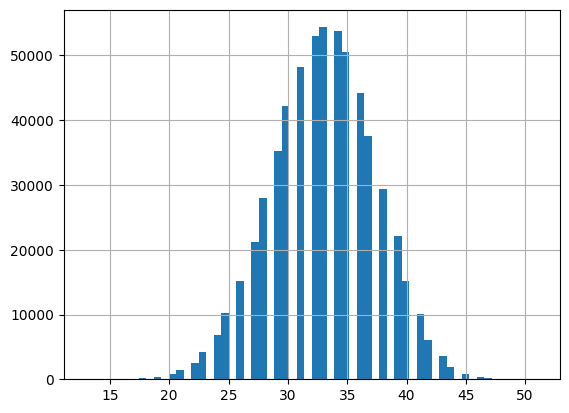

In [ ]:
generated_df['c_quantity'].hist(bins=60)

<Axes: >

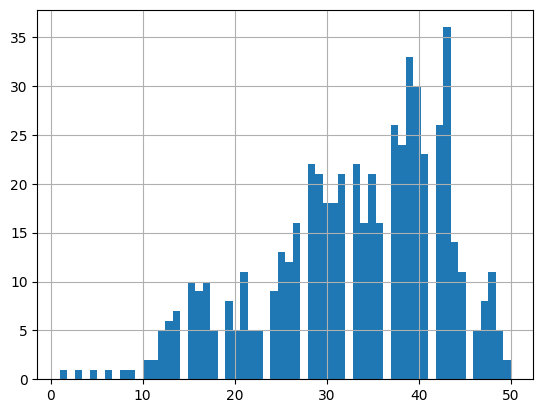

In [ ]:
cert_data['c_quantity'].hist(bins=60)

#Генерация данных с помощью пакета SDV

In [ ]:
mask_for_data = [x for x in cert_data.columns if x.endswith('quantity')]

In [ ]:
cert_data.loc[:, mask_for_data]

,c_quantity,block_1_c_quantity,block_2_c_quantity,block_3_c_quantity,block_4_c_quantity,block_5_c_quantity,block_6_c_quantity,block_7_c_quantity,block_8_c_quantity,block_9_c_quantity,block_10_c_quantity,block_11_c_quantity,block_12_c_quantity
idx,,,,,,,,,,,,,
0,17,2,1,1,1,2,1,1,2,2,2,2,0
1,27,5,4,3,2,2,3,2,0,3,2,0,1
2,15,3,2,0,0,0,1,3,0,2,0,2,2
3,23,2,3,1,0,2,3,3,2,2,2,2,1
4,24,2,3,2,0,1,3,4,1,3,2,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
570,39,3,3,3,3,3,3,4,3,5,3,3,3
571,36,3,4,2,3,3,2,3,2,4,3,3,4
572,38,3,3,3,2,3,3,4,2,5,4,3,3


In [ ]:
!pip install sdv

In [ ]:
from sdv.metadata import SingleTableMetadata

metadata = SingleTableMetadata()
metadata.detect_from_dataframe(data=cert_data.loc[:, mask_for_data])

In [ ]:
metadata.validate()

In [ ]:
from sdv.single_table import TVAESynthesizer

# synthesizer = TVAESynthesizer(metadata)

synthesizer = TVAESynthesizer(
    metadata, # required
    enforce_min_max_values=True,
    enforce_rounding=False,
    epochs=1000
)

synthesizer.fit(cert_data.loc[:, mask_for_data])

generated_df_two = synthesizer.sample(num_rows=600000)

/usr/local/lib/python3.10/dist-packages/rdt/transformers/base.py:132: FutureWarning: Future versions of RDT will not support the 'model_missing_values' parameter. Please switch to using the 'missing_value_generation' parameter to select your strategy.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/rdt/transformers/base.py:132: FutureWarning: Future versions of RDT will not support the 'model_missing_values' parameter. Please switch to using the 'missing_value_generation' parameter to select your strategy.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/rdt/transformers/base.py:132: FutureWarning: Future versions of RDT will not support the 'model_missing_values' parameter. Please switch to using the 'missing_value_generation' parameter to select your strategy.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/rdt/transformers/base.py:132: FutureWarning: Future versions of RDT will not support the 'model_missing_values' parameter. Please switch to using the 'mi

In [ ]:
from sdv.single_table import TVAESynthesizer

# synthesizer = TVAESynthesizer(metadata)

synthesizer = TVAESynthesizer(
    metadata, # required
    enforce_min_max_values=True,
    enforce_rounding=False,
    epochs=10000
)

synthesizer.fit(cert_data.loc[:, mask_for_data])

generated_df_three = synthesizer.sample(num_rows=600000)

/usr/local/lib/python3.10/dist-packages/rdt/transformers/base.py:132: FutureWarning: Future versions of RDT will not support the 'model_missing_values' parameter. Please switch to using the 'missing_value_generation' parameter to select your strategy.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/rdt/transformers/base.py:132: FutureWarning: Future versions of RDT will not support the 'model_missing_values' parameter. Please switch to using the 'missing_value_generation' parameter to select your strategy.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/rdt/transformers/base.py:132: FutureWarning: Future versions of RDT will not support the 'model_missing_values' parameter. Please switch to using the 'missing_value_generation' parameter to select your strategy.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/rdt/transformers/base.py:132: FutureWarning: Future versions of RDT will not support the 'model_missing_values' parameter. Please switch to using the 'mi

<Axes: >

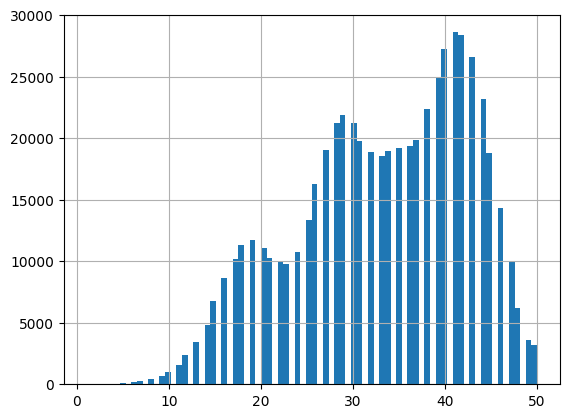

In [ ]:
generated_df_two['c_quantity'].hist(bins=80)

<Axes: >

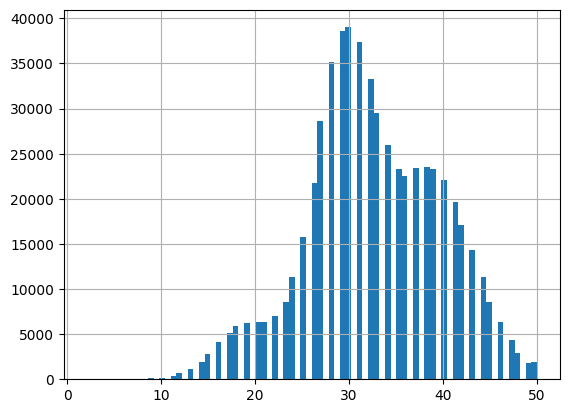

In [ ]:
generated_df_three['c_quantity'].hist(bins=80)

In [ ]:
synthesizer.get_parameters()

{'enforce_min_max_values': True,
 'enforce_rounding': False,
 'embedding_dim': 128,
 'compress_dims': (128, 128),
 'decompress_dims': (128, 128),
 'l2scale': 1e-05,
 'batch_size': 500,
 'epochs': 10000,
 'loss_factor': 2,
 'cuda': True}

In [ ]:
from sdv.single_table import CopulaGANSynthesizer

# synthesizer = CopulaGANSynthesizer(metadata)

synthesizer = CopulaGANSynthesizer(
    metadata, # required
    enforce_min_max_values=True,
    enforce_rounding=False,
    epochs=1000,
    # verbose=True
)

synthesizer.fit(cert_data.loc[:, mask_for_data])



generated_df_fourth = synthesizer.sample(num_rows=600000)

/usr/local/lib/python3.10/dist-packages/rdt/transformers/base.py:132: FutureWarning: Future versions of RDT will not support the 'model_missing_values' parameter. Please switch to using the 'missing_value_generation' parameter to select your strategy.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/rdt/transformers/base.py:132: FutureWarning: Future versions of RDT will not support the 'model_missing_values' parameter. Please switch to using the 'missing_value_generation' parameter to select your strategy.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/rdt/transformers/base.py:132: FutureWarning: Future versions of RDT will not support the 'model_missing_values' parameter. Please switch to using the 'missing_value_generation' parameter to select your strategy.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/rdt/transformers/base.py:132: FutureWarning: Future versions of RDT will not support the 'model_missing_values' parameter. Please switch to using the 'mi

In [ ]:
synthesizer.get_parameters()

{'enforce_min_max_values': True,
 'enforce_rounding': False,
 'locales': None,
 'embedding_dim': 128,
 'generator_dim': (256, 256),
 'discriminator_dim': (256, 256),
 'generator_lr': 0.0002,
 'generator_decay': 1e-06,
 'discriminator_lr': 0.0002,
 'discriminator_decay': 1e-06,
 'batch_size': 500,
 'discriminator_steps': 1,
 'log_frequency': True,
 'verbose': False,
 'epochs': 1000,
 'pac': 10,
 'cuda': True,
 'numerical_distributions': {},
 'default_distribution': 'beta'}

<Axes: >

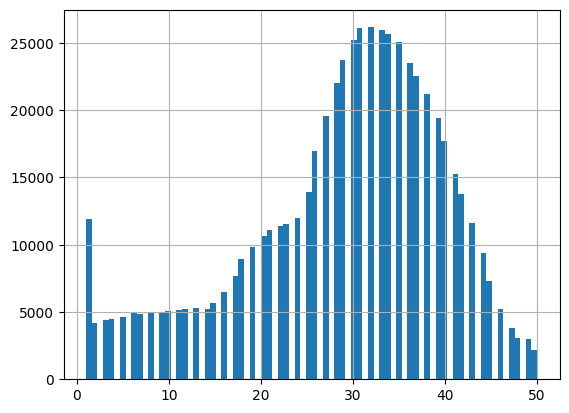

In [ ]:
generated_df_fourth['c_quantity'].hist(bins=80)

<Axes: >

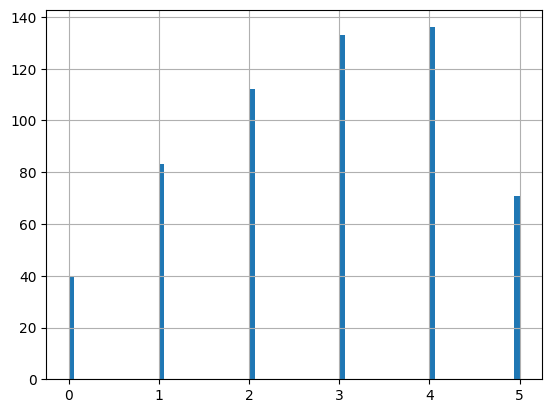

In [ ]:
cert_data['block_4_c_quantity'].hist(bins=80)

In [ ]:
for i, j in enumerate((generated_df, generated_df_two, generated_df_three, generated_df_fourth)):
    pd.concat([cert_data.loc[:, mask_for_data], j], axis=0)\
    .to_csv(f'/content/drive/MyDrive/НИР Магистратура/Работа со всеми данными/Аугментация/GeneratedDatasets/cert_test_data_extended_{i}.csv')
    print(i, 'dataset processed and loaded')

0 dataset processed and loaded
1 dataset processed and loaded
2 dataset processed and loaded
3 dataset processed and loaded
